In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import keyedvectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Connect to database

In [ ]:
#Load database
conn = sqlite3.connect('amazon_food_reviews.sqlite')

original_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""", conn)

original_data.head()

## Data preprocessing

In [ ]:
# Replace number rating with positive and negative strings
print(f'Size after droping duplicates {original_data.size}')
original_data = original_data.drop_duplicates({"UserId", "ProfileName", "Time", "Text"})

original_data["Score"] = original_data["Score"].map(lambda x: "positive" if x > 3 else "negative")
print(f'Size before droping duplicates {original_data.size}')

In [ ]:
original_data = original_data[original_data.HelpfulnessDenominator >= original_data.HelpfulnessNumerator]
print(f'Size after droping Helpfulness denominator greater than Numerator {original_data.size}')

In [ ]:
#Number of positive and negative reviews
original_data["Score"].value_counts()


#### We are concerned only about the Reviews and the score column so extract those in to a new variable

In [ ]:
filtered_data = original_data.loc[:,["Time","Score","Text"]]

np_random_perm = np.random.permutation(30000)

filtered_data = filtered_data[filtered_data.Score == "positive"].iloc[np_random_perm, :]. \
                    append(filtered_data[filtered_data.Score == "negative"].iloc[np_random_perm, :])

filtered_data = filtered_data.sort_values(by=['Time'])

print(filtered_data.shape)
print(filtered_data.isnull().any())
print(filtered_data.head())
print(filtered_data.tail())

## Text preprocessing : Remove Html Tags, Punctuations, alphanumerics and stop words. 

1. Obtain stem words for the remaining words and run algorithm using the data
2. Obtain lemma for each word and run algorithm using the data

In [3]:
# Code copied from the description python note book

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

#### Clean the reviews

In [ ]:
processed_reviews=[]

for (index, review) in enumerate(filtered_data["Text"].values):
    processedReviewWords = []
    cleanedReview = cleanpunc(cleanhtml(review))
    for word in cleanedReview.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedReviewWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_reviews.append(b" ".join(processedReviewWords))
    
print(processed_reviews[:5])

#### Append the cleaned text to the table with the normal text

In [ ]:
filtered_data["CleanedText"] = processed_reviews
filtered_data["CleanedText"] = filtered_data["CleanedText"].str.decode("utf-8")
filtered_data.head()

#### Import libraries for Clasification

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(filtered_data['Score'], classes=['negative','positive']) 
# negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array

## Split data in to train and test

In [9]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(filtered_data["CleanedText"], encoded_labels,\
                                                                     test_size=0.3, random_state=0, shuffle = False)

## Common Functions definitions

In [10]:
def ColumnStandardization(train_data, test_data):
    """ Column standardization to get unit variance.
    with_mean is set to false so that it works for sparse matrix
    """
    standardizer = StandardScaler(with_mean=False)
    std_train_data = standardizer.fit_transform(train_data)
    std_test_data = standardizer.transform(test_data)
    return (std_train_data, std_test_data)

In [11]:
def Svc_Classifier(train_features, train_class, test_features, test_class, X_SearchCV):
    """
    1. Calculates C and gaama value
    2. Plots cross validation erros v/s the alpha values
    3. Plots confusion matrix for the predictions
    """
    
    powers_of_ten = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    hyper_parameters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},\
                        {'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

    model = X_SearchCV(SVC(kernel='rbf'), hyper_parameters, cv=5, \
                                        scoring='accuracy')
    
    model.fit(train_features, train_class)
    print(model.best_estimator_)
    acc = model.score(test_features, test_class) * float(100)
    
    predictions = model.predict(test_features)

    f1 = f1_score(test_class, predictions) * float(100)
    precision = precision_score(test_class, predictions) * float(100)
    recall = recall_score(test_class, predictions) * float(100)
    
    print(f'Accuracy = {acc}') 
    print(f'F1 Score = {f1}') 
    print(f'Precision = {precision}') 
    print(f'Recall = {recall}') 
    
    df_cm = pd.DataFrame(data=confusion_matrix(test_class, predictions),index=range(2),columns= ['Negative','Positive'])
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

    return model

In [12]:
import scipy

In [29]:
def Svc_Classifier_RandomSearch(train_features, train_class, test_features, test_class, X_SearchCV):
    """
    1. Calculates C and gaama value
    2. Plots cross validation erros v/s the alpha values
    3. Plots confusion matrix for the predictions
    """
    
    hyper_parameters = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
   
    model = X_SearchCV(SVC(kernel='rbf'), hyper_parameters, cv=5, \
                                        scoring='accuracy')
    
    model.fit(train_features, train_class)
    print(model.best_estimator_)
    acc = model.score(test_features, test_class) * float(100)
    
    predictions = model.predict(test_features)

    f1 = f1_score(test_class, predictions) * float(100)
    precision = precision_score(test_class, predictions) * float(100)
    recall = recall_score(test_class, predictions) * float(100)
    
    print(f'Accuracy = {acc}') 
    print(f'F1 Score = {f1}') 
    print(f'Precision = {precision}') 
    print(f'Recall = {recall}') 
    
    df_cm = pd.DataFrame(data=confusion_matrix(test_class, predictions),index=range(2),columns= ['Negative','Positive'])
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

    return model

### Bag Of Words

In [9]:
count_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=5)

#fit and transform train data
bow_X_tr = count_vectorizer.fit_transform(X_train)

# transform test data, note that i am not fitting the vectorizer just transforming the test data
bow_X_test = count_vectorizer.transform(X_test)

(bow_X_tr, bow_X_test) = ColumnStandardization(bow_X_tr, bow_X_test)

print(type(bow_X_tr))
print(f"Shape of final_bigrams : {bow_X_tr.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 69090)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Run Classifier

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy = 88.39444444444445
F1 Score = 88.1944051992088
Precision = 89.00422037184897
Recall = 87.3991935483871


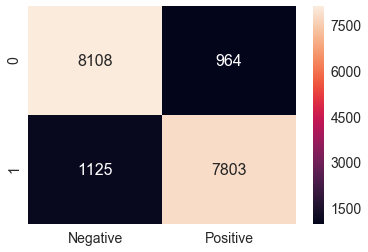

In [10]:
model = Svc_Classifier(train_features = bow_X_tr, train_class = Y_train, \
                                     test_features = bow_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

#### How accuracy changes with C for gaama regularization

In [11]:
model.grid_scores_

[mean: 0.50171, std: 0.00002, params: {'C': 0.001},
 mean: 0.53655, std: 0.00751, params: {'C': 0.01},
 mean: 0.58348, std: 0.00859, params: {'C': 0.1},
 mean: 0.87374, std: 0.00382, params: {'C': 1},
 mean: 0.86469, std: 0.00425, params: {'C': 10},
 mean: 0.86221, std: 0.00480, params: {'C': 100},
 mean: 0.86250, std: 0.00477, params: {'C': 1000},
 mean: 0.50431, std: 0.00067, params: {'gamma': 0.001},
 mean: 0.50286, std: 0.00044, params: {'gamma': 0.01},
 mean: 0.50271, std: 0.00039, params: {'gamma': 0.1},
 mean: 0.50267, std: 0.00040, params: {'gamma': 1},
 mean: 0.50269, std: 0.00038, params: {'gamma': 10},
 mean: 0.50269, std: 0.00038, params: {'gamma': 100},
 mean: 0.50269, std: 0.00038, params: {'gamma': 1000}]

### TFIDF

In [13]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_X_tr = tfidf_vectorizer.fit_transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)
(tfidf_X_tr, tfidf_X_test) = ColumnStandardization(tfidf_X_tr, tfidf_X_test)
print(type(tfidf_X_tr))
print(f"Shape of final_bigrams : {tfidf_X_tr.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (42000, 60455)


In [12]:
from sklearn.model_selection import RandomizedSearchCV

### Run classifier

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
def GetTruncatedFeatures(train_data, test_data):
    svd = TruncatedSVD(n_components=20000)
    ret_train_data = svd.fit_transform(train_data)
    ret_test_data = svd.trasform(test_data)
    return ret_train_data, ret_test_data

In [ ]:
tfidf_X_tr_reduced , tfidf_X_test_reduced = GetTruncatedFeatures(tfidf_X_tr, tfidf_X_test)

In [7]:
tfidf_X_tr_reduced = OpenFile(r'D:\Studies\AppliedAi\AmazonFoodReviews\tfidf_X_tr_reduced.p')
tfidf_X_test_reduced = OpenFile(r'D:\Studies\AppliedAi\AmazonFoodReviews\tfidf_X_test_reduced.p')

In [10]:
Y_train = OpenFile(r'D:\Studies\AppliedAi\AmazonFoodReviews\Y_train.p')
Y_test = OpenFile(r'D:\Studies\AppliedAi\AmazonFoodReviews\Y_test.p')

In [14]:
hyper_parameters = {'gamma':[10,5,1,0.5,0.1,0.05,0.01],
             'C':[100,50,10,5,1,0.5,0.1]}

model = RandomizedSearchCV(SVC(kernel='rbf'), hyper_parameters, cv=5, \
                                        scoring='accuracy')
    
model.fit(tfidf_X_tr_reduced, Y_train)
print(model.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Accuracy = 52.87222222222222
F1 Score = 65.27203504318992
Precision = 48.75244618395303
Recall = 98.72445820433437


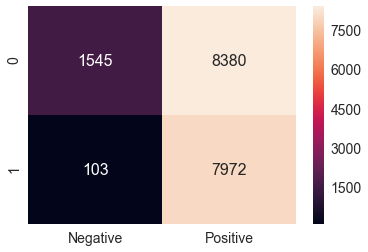

In [15]:
acc = model.score(tfidf_X_test_reduced, Y_test) * float(100)
predictions = model.predict(tfidf_X_test_reduced)

f1 = f1_score(Y_test, predictions) * float(100)
precision = precision_score(Y_test, predictions) * float(100)
recall = recall_score(Y_test, predictions) * float(100)
  
print(f'Accuracy = {acc}') 
print(f'F1 Score = {f1}') 
print(f'Precision = {precision}') 
print(f'Recall = {recall}') 
 
df_cm = pd.DataFrame(data=confusion_matrix(Y_test, predictions),index=range(2),columns= ['Negative','Positive'])
  
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [15]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-]',r' ',cleaned)
    return  cleaned

In [16]:
def Get_List_of_Sentences(cleanedText):
    list_of_sent=[]
    for sent in cleanedText:
        list_of_sent.append(cleanpunc(sent).split())
    return list_of_sent

In [17]:
def Get_Word2Vec_Vectors(list_of_sent):
    w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    return w2v_model

In [18]:
def GetAvgW2V_Vectors(list_of_sent, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors

In [19]:
X_tr_listOfSent = Get_List_of_Sentences(X_train)
X_test_listOfSent = Get_List_of_Sentences(X_test)
X_tr_w2vModel = Get_Word2Vec_Vectors(X_tr_listOfSent)

In [38]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avg_X_tr = GetAvgW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel)
avg_X_test = GetAvgW2V_Vectors(X_test_listOfSent, X_tr_w2vModel)
(avg_X_tr, avg_X_test) = ColumnStandardization(avg_X_tr, avg_X_test)

In [20]:
def GetTfIdfW2V_Vectors(list_of_sent, w2v_model, final_tfidf):
    # TF-IDF weighted Word2Vec
    tfidf_feat = tfidf_vectorizer.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
    w2v_words = list(w2v_model.wv.vocab)
    print(f'number of sentences = {len(list_of_sent)}')
    for (row,sent) in enumerate(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if (word in w2v_words) and (word in tfidf_feat):
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = final_tfidf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        print(f'Sentence number {row}', end = "\r")
    
    return tfidf_sent_vectors

In [21]:
# Get Average word2vec vector for each set of data -> Column standardize those vectors
avgtfidf_X_tr = GetTfIdfW2V_Vectors(X_tr_listOfSent, X_tr_w2vModel, tfidf_X_tr)

number of sentences = 42000


In [22]:
avgtfidf_X_test = GetTfIdfW2V_Vectors(X_test_listOfSent, X_tr_w2vModel, tfidf_X_test)
(avgtfidf_X_tr, avgtfidf_X_test) = ColumnStandardization(avgtfidf_X_tr, avgtfidf_X_test)

number of sentences = 18000


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy = 85.64444444444445
F1 Score = 85.45045045045046
Precision = 85.91485507246377
Recall = 84.9910394265233


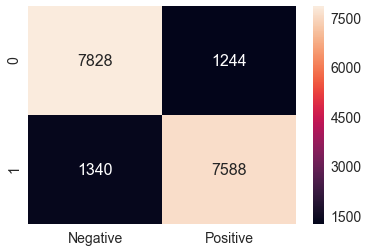

In [53]:
model_avg_w2v = Svc_Classifier(train_features = avg_X_tr, train_class = Y_train, \
                                     test_features = avg_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

#### How accuracy changes with C for gaama regularization

In [11]:
model.grid_scores_

[mean: 0.50171, std: 0.00002, params: {'C': 0.001},
 mean: 0.53655, std: 0.00751, params: {'C': 0.01},
 mean: 0.58348, std: 0.00859, params: {'C': 0.1},
 mean: 0.87374, std: 0.00382, params: {'C': 1},
 mean: 0.86469, std: 0.00425, params: {'C': 10},
 mean: 0.86221, std: 0.00480, params: {'C': 100},
 mean: 0.86250, std: 0.00477, params: {'C': 1000},
 mean: 0.50431, std: 0.00067, params: {'gamma': 0.001},
 mean: 0.50286, std: 0.00044, params: {'gamma': 0.01},
 mean: 0.50271, std: 0.00039, params: {'gamma': 0.1},
 mean: 0.50267, std: 0.00040, params: {'gamma': 1},
 mean: 0.50269, std: 0.00038, params: {'gamma': 10},
 mean: 0.50269, std: 0.00038, params: {'gamma': 100},
 mean: 0.50269, std: 0.00038, params: {'gamma': 1000}]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy = 83.56666666666666
F1 Score = 83.27868852459015
Precision = 84.06756448299475
Recall = 82.50448028673834


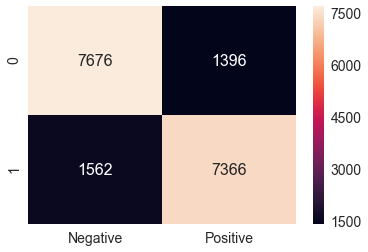

In [23]:
model_avgtfidf_w2v = Svc_Classifier(train_features = avgtfidf_X_tr, train_class = Y_train, \
                                     test_features = avgtfidf_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

In [ ]:
def Svc_linear_Classifier(train_features, train_class, test_features, test_class, X_SearchCV):
    """
    1. Calculates C and gaama value
    2. Plots cross validation erros v/s the alpha values
    3. Plots confusion matrix for the predictions
    """
    
    powers_of_ten = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    hyper_parameters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},\
                        {'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

    model = X_SearchCV(SVC(kernel='linear'), hyper_parameters, cv=5, \
                                        scoring='accuracy')
    
    model.fit(train_features, train_class)
    print(model.best_estimator_)
    acc = model.score(test_features, test_class) * float(100)
    
    predictions = model.predict(test_features)

    f1 = f1_score(test_class, predictions) * float(100)
    precision = precision_score(test_class, predictions) * float(100)
    recall = recall_score(test_class, predictions) * float(100)
    
    print(f'Accuracy = {acc}') 
    print(f'F1 Score = {f1}') 
    print(f'Precision = {precision}') 
    print(f'Recall = {recall}') 
    
    df_cm = pd.DataFrame(data=confusion_matrix(test_class, predictions),index=range(2),columns= ['Negative','Positive'])
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

    return model

In [ ]:
model_avgtfidf_w2v_linear = Svc_linear_Classifier(train_features = avgtfidf_X_tr, train_class = Y_train, \
                                     test_features = avgtfidf_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

In [ ]:
model_avg_w2v_linear = Svc_linear_Classifier(train_features = avg_X_tr, train_class = Y_train, \
                                     test_features = avg_X_test, test_class = Y_test, X_SearchCV = GridSearchCV)

# Conclusion

In [16]:
conclusion = {'Alogrithm' : ['Bow', 'Tfidf', 'Avg_w2v', 'Tfidf_w2v'], \
              'Accuracy' : [88.39, 52.87, 85.64, 83.56]}
df_conclusion = pd.DataFrame(data=conclusion)

df_conclusion

,Alogrithm,Accuracy
0,Bow,88.39
1,Tfidf,52.87
2,Avg_w2v,85.64
3,Tfidf_w2v,83.56


1. Grid search is not fast and takes a lot of time in training.
2. Bag of words showed better performance than any other featurization
3. The lower value of accuracy for tfidf is because we used rbf kernel. Linear kernel produces better results. 

In [4]:
import pickle

In [5]:
def OpenFile(fileName):
    return pickle.load(open(fileName, 'rb'))